# Deep Learning vs Traditional ML for Anomaly Detection

## General Imports

In [1]:
# Import libraries to verify installation
import seaborn as sns
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from datetime import datetime
from matplotlib.colors import Normalize
import tqdm
import PIL
import pickle
import sys
import json
from scipy.stats import skew
from imblearn.combine import SMOTEENN

#tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.data import AUTOTUNE
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

## Dataset 

In [2]:
df = pd.read_csv('data.csv')

In [3]:
print(df.shape)
df.head()

(5000000, 20)


,timestamp,aimp,amud,arnd,asin1,asin2,adbr,adfl,bed1,bed2,bfo1,bfo2,bso1,bso2,bso3,ced1,cfo1,cso1,y,category
0,2023-01-01 00:00:00,0.0,1.0,20.000000,0.00000,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
1,2023-01-01 00:00:01,0.0,1.0,20.080031,0.00002,0.0002,0.0,0.0,0.0,0.0,0.0,4.993912e-07,0.000789,0.0,0.0,0.0,0.000021,0.001229,0.0,0.0
2,2023-01-01 00:00:02,0.0,1.0,20.276562,0.00004,0.0004,0.0,0.0,0.0,0.0,0.0,1.496957e-06,0.003115,0.0,0.0,0.0,0.000104,0.004833,0.0,0.0
3,2023-01-01 00:00:03,0.0,1.0,20.730938,0.00006,0.0006,0.0,0.0,0.0,0.0,0.0,2.991484e-06,0.006914,0.0,0.0,0.0,0.000285,0.010688,0.0,0.0
4,2023-01-01 00:00:04,0.0,1.0,21.118101,0.00008,0.0008,0.0,0.0,0.0,0.0,0.0,4.981761e-06,0.012123,0.0,0.0,0.0,0.000601,0.018669,0.0,0.0


### EDA and Preprocessing

In [4]:
# split the data into x and y dataframes

X_df = df.drop('y', axis=1)
y_df = df['y']

In [5]:
print(X_df.shape)
X_df.head()

(5000000, 19)


,timestamp,aimp,amud,arnd,asin1,asin2,adbr,adfl,bed1,bed2,bfo1,bfo2,bso1,bso2,bso3,ced1,cfo1,cso1,category
0,2023-01-01 00:00:00,0.0,1.0,20.000000,0.00000,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
1,2023-01-01 00:00:01,0.0,1.0,20.080031,0.00002,0.0002,0.0,0.0,0.0,0.0,0.0,4.993912e-07,0.000789,0.0,0.0,0.0,0.000021,0.001229,0.0
2,2023-01-01 00:00:02,0.0,1.0,20.276562,0.00004,0.0004,0.0,0.0,0.0,0.0,0.0,1.496957e-06,0.003115,0.0,0.0,0.0,0.000104,0.004833,0.0
3,2023-01-01 00:00:03,0.0,1.0,20.730938,0.00006,0.0006,0.0,0.0,0.0,0.0,0.0,2.991484e-06,0.006914,0.0,0.0,0.0,0.000285,0.010688,0.0
4,2023-01-01 00:00:04,0.0,1.0,21.118101,0.00008,0.0008,0.0,0.0,0.0,0.0,0.0,4.981761e-06,0.012123,0.0,0.0,0.0,0.000601,0.018669,0.0


In [6]:
print(y_df.shape)  
y_df.head() 

(5000000,)


0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: y, dtype: float64

This section is dedicated to the exploratory data analysis of the dataset. Upon loading the dataset, we check its basic information.

In [7]:
# check for missing values

df.isnull().sum()

timestamp    0
aimp         0
amud         0
arnd         0
asin1        0
asin2        0
adbr         0
adfl         0
bed1         0
bed2         0
bfo1         0
bfo2         0
bso1         0
bso2         0
bso3         0
ced1         0
cfo1         0
cso1         0
y            0
category     0
dtype: int64

In [6]:
# load metadata csv

df_metadata = pd.read_csv('metadata.csv')

In [9]:
print(df_metadata.shape)
df_metadata.head()

(200, 5)


,start_time,end_time,root_cause,affected,category
0,2023-01-12 15:11:45,2023-01-12 15:20:05,bso3,['cfo1'],12
1,2023-01-12 16:27:46,2023-01-12 17:51:06,bso3,['cfo1'],1
2,2023-01-12 18:19:35,2023-01-12 18:36:15,bfo2,['cso1'],8
3,2023-01-12 20:46:32,2023-01-12 20:51:32,bed2,['ced1'],7
4,2023-01-13 05:57:10,2023-01-13 06:02:10,bfo1,['cfo1'],9


In [7]:
df_metadata.category.value_counts()

category
8     28
3     22
12    20
7     20
9     18
4     15
5     13
2     13
13    12
6     12
1     11
10    10
11     6
Name: count, dtype: int64

From the metadata, we can see that we have 200 batches of injected anomalies. And, in each batch, we can see the root cause of the anomaly.

No missing values!

In [85]:
# check for class imbalance

y_df.value_counts()

y
0.0    4809900
1.0     190100
Name: count, dtype: int64

In [86]:
# check for labels in first 1000000 rows

y_df[:1000000].value_counts()

y
0.0    1000000
Name: count, dtype: int64

In [87]:
y_df[1000000:].value_counts()

y
0.0    3809900
1.0     190100
Name: count, dtype: int64

In [88]:
X_df['category'].value_counts()

category
0.0     4809900
8.0       32600
1.0       20400
12.0      19600
7.0       19100
3.0       18000
4.0       15600
6.0       12100
2.0       12000
9.0       10400
5.0        9900
11.0       9100
10.0       6400
13.0       4900
Name: count, dtype: int64

This is as expected as the first 1000000 rows are the normal data and the remaining 4000000 rows contain both normal and anomalous data. Futhermore each anomaly has its own category identified, which is listed in the metadata.

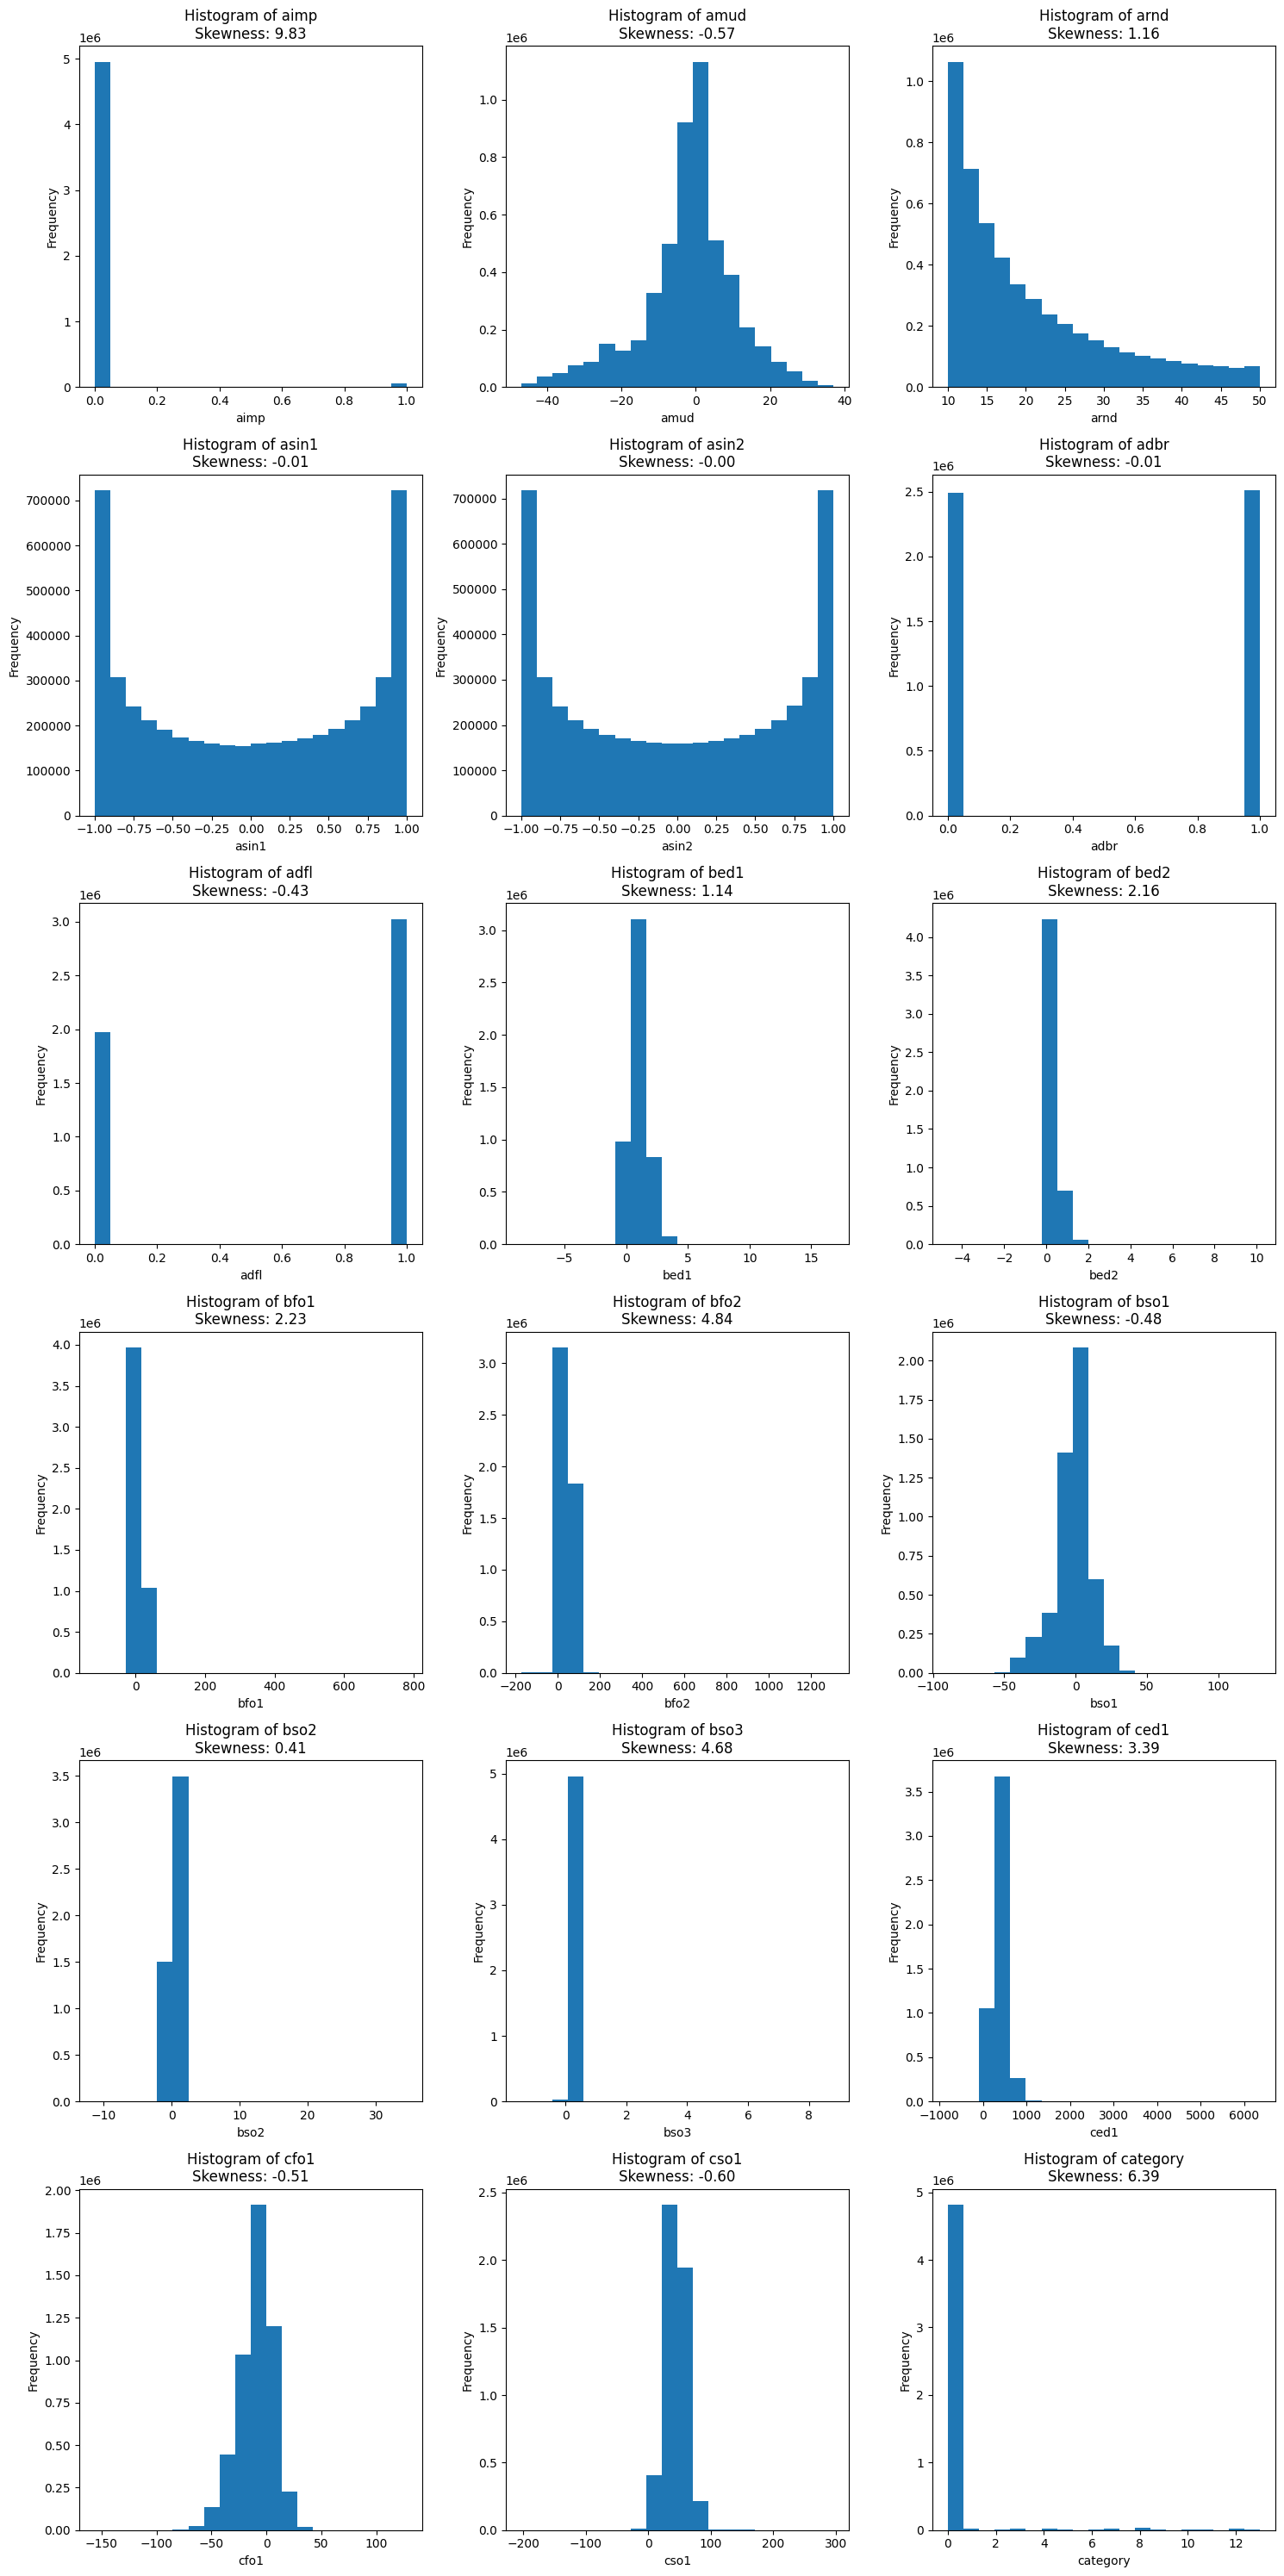

In [8]:
# Plot histograms for each numeric feature
numeric_features = X_df.select_dtypes(include=['float64', 'int64'])  # Select numeric features
numeric_columns = numeric_features.columns

num_plots = len(numeric_columns)
num_rows = int(np.ceil(num_plots/3)) # Adjust the number of rows as needed

fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))

for i, column in enumerate(numeric_columns):
    row = i // 3
    col = i % 3
    axes[row, col].hist(X_df[column], bins=20)  # Adjust the number of bins as needed
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].set_title(f'Histogram of {column}\nSkewness: {skew(df[column]):.2f}')

# Remove empty subplots
if num_plots % 3 != 0:
    for i in range(num_plots % 3, 3):
        fig.delaxes(axes[num_rows-1, i])

plt.tight_layout()
plt.show()


In [9]:
# check the features for which number of unique values is small

discrete_features = [feature for feature in numeric_columns if len(X_df[feature].unique()) < 100]

for feature in discrete_features:
    print(f'{feature}: {X_df[feature].unique()}')

aimp: [0. 1.]
amud: [  1.  -1.   2.   3.   6.   5.   0.  10.   7.   4.  -4.   9.  11.   8.
  16.  12.  -3.  -6.  -5. -12. -13.  -7.  -9.  -2. -10. -11.  -8. -15.
 -14. -17. -19. -21. -24. -23. -22. -25. -28. -16. -20. -30. -29. -26.
 -27. -32. -31. -34. -37. -35. -18.  13.  15.  14.  18.  21.  22.  25.
  26.  30.  27.  24.  23.  29.  28.  20.  19.  17. -33. -41. -38. -39.
 -44. -45. -36. -40. -43. -46. -42. -47.  31.  32.  33.  34.  37.  36.
  35.]
adbr: [0. 1.]
adfl: [0. 1.]
category: [ 0. 12.  1.  8.  7.  9.  4.  3.  5. 11. 10.  2. 13.  6.]


From this, we gathered that other than `category`, we have 4 features which have discrete values. Therefore, we make sure not to normalize these features (we only want to normalize the continuous features).

### Data Preprocessing

#### Correlation Analysis

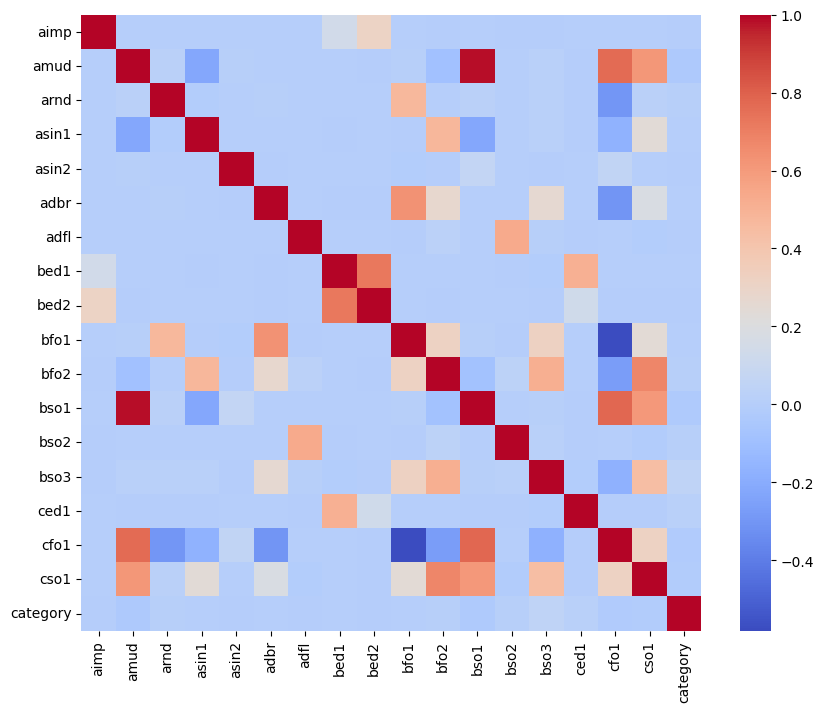

In [10]:
# check for correlation matrix between columns, using sns heatmap

corr = X_df.drop('timestamp', axis=1).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', linecolor='black')
plt.show()

In [11]:
# Set the correlation threshold
threshold = 0.9

# Empty dictionary to hold correlated variables

correlated_vars = {}

for column in corr.columns:
    for index in corr.index:
        if abs(corr.loc[index, column]) > threshold and index != column and column not in correlated_vars and column not in correlated_vars.values():
                print(f'{index} and {column} are correlated with a value of {corr.loc[index, column]}')
                correlated_vars[column] = index

print(correlated_vars)

bso1 and amud are correlated with a value of 0.9848983886247252
{'amud': 'bso1'}


In [12]:
columns_to_drop = list(correlated_vars.values())
X_df = X_df.drop(columns=columns_to_drop, axis=1)

In [17]:
print(X_df.shape)
X_df.head()

(5000000, 18)


,timestamp,aimp,amud,arnd,asin1,asin2,adbr,adfl,bed1,bed2,bfo1,bfo2,bso2,bso3,ced1,cfo1,cso1,category
0,2023-01-01 00:00:00,0.0,1.0,20.000000,0.00000,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.0
1,2023-01-01 00:00:01,0.0,1.0,20.080031,0.00002,0.0002,0.0,0.0,0.0,0.0,0.0,4.993912e-07,0.0,0.0,0.0,0.000021,0.001229,0.0
2,2023-01-01 00:00:02,0.0,1.0,20.276562,0.00004,0.0004,0.0,0.0,0.0,0.0,0.0,1.496957e-06,0.0,0.0,0.0,0.000104,0.004833,0.0
3,2023-01-01 00:00:03,0.0,1.0,20.730938,0.00006,0.0006,0.0,0.0,0.0,0.0,0.0,2.991484e-06,0.0,0.0,0.0,0.000285,0.010688,0.0
4,2023-01-01 00:00:04,0.0,1.0,21.118101,0.00008,0.0008,0.0,0.0,0.0,0.0,0.0,4.981761e-06,0.0,0.0,0.0,0.000601,0.018669,0.0


In [18]:
X_df.describe()

,aimp,amud,arnd,asin1,asin2,adbr,adfl,bed1,bed2,bfo1,bfo2,bso2,bso3,ced1,cfo1,cso1,category
count,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06
mean,1.004660e-02,-2.063128e+00,2.037560e+01,1.376862e-03,4.375382e-04,5.014428e-01,6.047880e-01,1.006633e+00,2.009579e-01,1.027840e+01,4.531630e+01,6.065850e-01,3.043164e-01,3.832717e+02,-9.272158e+00,4.385963e+01,2.468000e-01
std,9.972797e-02,1.247662e+01,1.003736e+01,7.086476e-01,7.069422e-01,4.999980e-01,4.888962e-01,7.204717e-01,3.226495e-01,1.091826e+01,1.500953e+01,6.998044e-01,1.086660e-01,1.527735e+02,1.596908e+01,1.813677e+01,1.422312e+00
min,0.000000e+00,-4.700000e+01,1.000000e+01,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,-8.488071e+00,-4.675346e+00,-1.175588e+02,-1.720937e+02,-1.126187e+01,-1.456883e+00,-8.080388e+02,-1.560371e+02,-2.030314e+02,0.000000e+00
25%,0.000000e+00,-7.000000e+00,1.246351e+01,-7.100338e-01,-7.065659e-01,0.000000e+00,0.000000e+00,4.508830e-01,1.047451e-03,8.006783e-01,3.678116e+01,1.709159e-02,2.326239e-01,2.815484e+02,-1.847354e+01,3.288450e+01,0.000000e+00
50%,0.000000e+00,0.000000e+00,1.683966e+01,8.296232e-03,1.525203e-03,1.000000e+00,1.000000e+00,8.957148e-01,3.490144e-02,8.445810e+00,4.535635e+01,7.062810e-01,3.018725e-01,3.676660e+02,-7.354781e+00,4.383317e+01,0.000000e+00
75%,0.000000e+00,5.000000e+00,2.549316e+01,7.100337e-01,7.069845e-01,1.000000e+00,1.000000e+00,1.415038e+00,2.756596e-01,1.519138e+01,5.393373e+01,1.135538e+00,3.729177e-01,4.667581e+02,1.262402e+00,5.502822e+01,0.000000e+00
max,1.000000e+00,3.700000e+01,5.000000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.677479e+01,1.014906e+01,7.803936e+02,1.306257e+03,3.451370e+01,8.804988e+00,6.354198e+03,1.275665e+02,2.961996e+02,1.300000e+01


In [13]:
# normalize the data using StandardScaler

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_df_scaled = X_df.copy()

#only normalize the columns that are not discrete
numeric_features = X_df.select_dtypes(include=['float64', 'int64'])  # Select numeric features
numeric_columns = numeric_features.columns
discrete_features = [feature for feature in numeric_columns if len(X_df[feature].unique()) < 100]

continuous_features = [feature for feature in numeric_columns if feature not in discrete_features]

X_df_scaled[continuous_features] = scaler.fit_transform(X_df[continuous_features])

X_df_scaled.head()

,timestamp,aimp,amud,arnd,asin1,asin2,adbr,adfl,bed1,bed2,bfo1,bfo2,bso2,bso3,ced1,cfo1,cso1,category
0,2023-01-01 00:00:00,0.0,1.0,-0.037420,-0.001943,-0.000619,0.0,0.0,-1.397187,-0.622837,-0.941396,-3.019169,-0.866792,-2.800477,-2.508759,0.580632,-2.418272,0.0
1,2023-01-01 00:00:01,0.0,1.0,-0.029447,-0.001915,-0.000336,0.0,0.0,-1.397187,-0.622837,-0.941396,-3.019169,-0.866792,-2.800477,-2.508759,0.580633,-2.418204,0.0
2,2023-01-01 00:00:02,0.0,1.0,-0.009867,-0.001886,-0.000053,0.0,0.0,-1.397187,-0.622837,-0.941396,-3.019169,-0.866792,-2.800477,-2.508759,0.580638,-2.418005,0.0
3,2023-01-01 00:00:03,0.0,1.0,0.035402,-0.001858,0.000230,0.0,0.0,-1.397187,-0.622837,-0.941396,-3.019169,-0.866792,-2.800477,-2.508759,0.580650,-2.417682,0.0
4,2023-01-01 00:00:04,0.0,1.0,0.073974,-0.001830,0.000513,0.0,0.0,-1.397187,-0.622837,-0.941396,-3.019169,-0.866792,-2.800477,-2.508759,0.580670,-2.417242,0.0


In [22]:
X_df_scaled.describe()

,aimp,amud,arnd,asin1,asin2,adbr,adfl,bed1,bed2,bfo1,bfo2,bso2,bso3,ced1,cfo1,cso1,category
count,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06
mean,1.004660e-02,-2.063128e+00,9.441464e-16,3.110472e-17,2.501110e-17,5.014428e-01,6.047880e-01,3.714831e-16,-4.863523e-16,1.615035e-16,7.210019e-16,-7.084225e-16,6.905793e-16,2.828438e-15,-8.176357e-17,3.965306e-15,2.468000e-01
std,9.972797e-02,1.247662e+01,1.000000e+00,1.000000e+00,1.000000e+00,4.999980e-01,4.888962e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.422312e+00
min,0.000000e+00,-4.700000e+01,-1.033698e+00,-1.413082e+00,-1.415162e+00,0.000000e+00,0.000000e+00,-1.317846e+01,-1.511332e+01,-1.170857e+01,-1.448480e+01,-1.695967e+01,-1.620746e+01,-7.797889e+00,-9.190572e+00,-1.361274e+01,0.000000e+00
25%,0.000000e+00,-7.000000e+00,-7.882639e-01,-1.003899e+00,-1.000087e+00,0.000000e+00,0.000000e+00,-7.713703e-01,-6.195903e-01,-8.680618e-01,-5.686484e-01,-8.423689e-01,-6.597518e-01,-6.658446e-01,-5.761999e-01,-6.051318e-01,0.000000e+00
50%,0.000000e+00,0.000000e+00,-3.522785e-01,9.764191e-03,1.538548e-03,1.000000e+00,1.000000e+00,-1.539528e-01,-5.146653e-01,-1.678467e-01,2.668184e-03,1.424627e-01,-2.249044e-02,-1.021495e-01,1.200681e-01,-1.459417e-03,0.000000e+00
75%,0.000000e+00,5.000000e+00,5.098516e-01,1.000013e+00,9.994410e-01,1.000000e+00,1.000000e+00,5.668580e-01,2.315259e-01,4.499780e-01,5.741304e-01,7.558591e-01,6.313039e-01,5.464714e-01,6.596848e-01,6.157977e-01,0.000000e+00
max,1.000000e+00,3.700000e+01,2.951414e+00,1.409196e+00,1.413924e+00,1.000000e+00,1.000000e+00,2.188589e+01,3.083255e+01,7.053460e+01,8.400934e+01,4.845228e+01,7.822756e+01,3.908354e+01,8.568976e+00,1.391317e+01,1.300000e+01


Now our dataset is standardized. we can proceed with data augmentation. We will use the SMOTE technique to balance the dataset.

In [23]:
# Test case where we perform a train test split without data augmentation

X_train, X_test, y_train, y_test = train_test_split(X_df_scaled, y_df, test_size=0.2, random_state=42, shuffle=True)

# Verify the split
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)
print("Training set contamination rate:", np.mean(y_train))
print("Test set contamination rate:", np.mean(y_test))

Training set size: (4000000, 18)
Test set size: (1000000, 18)
Training set contamination rate: 0.038024
Test set contamination rate: 0.038004


In [14]:
# data augmentation using SMOTEENN, a combination of SMOTE and Edited Nearest Neighbours

# drop timestamps

X_df_scaled_no_time = X_df_scaled.drop('timestamp', axis=1)

# Perform data augmentation using SMOTEENN

smote_enn = SMOTEENN(random_state=42)

X_resampled, y_resampled = smote_enn.fit_resample(X_df_scaled_no_time, y_df)

# Test case where we perform a train test split with data augmentation

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, shuffle=True)

# Verify the split

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)
print("Training set contamination rate:", np.mean(y_train))
print("Test set contamination rate:", np.mean(y_test))